In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz, lfilter


import seaborn as sns
sns.set_style("white")

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

In [2]:
I =1
Q = 0.3
U = 0.5
V = 0.0
cov = np.array([[I+Q,U,0,V],
              [U,I-Q,V,0],
              [0,V,I+Q,U],
              [V,0,U, I-Q]])

In [3]:
modes = np.random.multivariate_normal(np.zeros(4),cov,2**12+1)

In [4]:
sxf = modes[:,0]+1j*modes[:,2]
syf = modes[:,1]+1j*modes[:,3]

In [5]:
sx = np.fft.irfft(sxf)
sy = np.fft.irfft(syf)

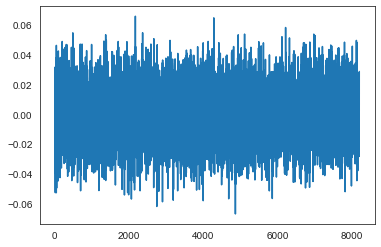

In [6]:
plt.plot(sx)

#### When averaging by changing the shape of the signal. Should It be averaged for every observable we will be looking for? 
#### Should we average and then make the required transformations or usage in functions or the other way around?

In [7]:
Fx = np.fft.rfft(sx)
Fy = np.fft.rfft(sy)
def PS (a,b=None):
    if b is None:
        prod = np.real(a*np.conj(a))
    else:
        prod = a*np.conj(b)
    print("prod",prod.shape)
    binPk = prod[1:].reshape((2**7,-1)).mean(axis=-1)
    
    return binPk

In [8]:
len(Fx)

4097

In [9]:
Pxx = PS(Fx)
Pyy = PS(Fy)
Pxy = PS(Fx,Fy)
Pyx = PS(Fy,Fx)
I = Pxx+Pyy
Q = Pxx-Pyy
U = np.real(Pxy+Pyx)    # from wikipedia
V = np.imag(Pxy-Pyx)
N = np.mean(I)
I/=N
Q/=N
U/=N
V/=N
#len(Pxx[0])

prod (4097,)
prod (4097,)
prod (4097,)
prod (4097,)


In [10]:
#print(I**2)

In [11]:
#print(Q**2+U**2+V**2)

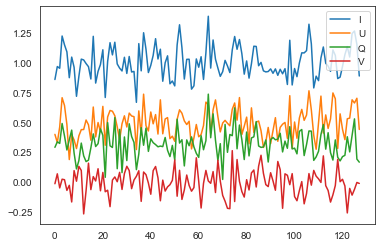

In [12]:
plt.plot(I,label="I")
plt.plot(U,label="U")
plt.plot(Q,label="Q")
plt.plot(V,label="V")
plt.legend()


In [13]:
# Define change in angle here
c = 3e8

def faraday_rotation_angle(w):
    if w==0:
        far_angle = 0
    else:
        far_angle = 0.1*c**2/w**2
    
    return far_angle

In [14]:
len(sx)

8192

In [15]:
time = np.linspace(0.0,0.01,len(sx),endpoint=False)
npts = len(time)

In [16]:
k = np.fft.rfftfreq(len(time))
kfreq = k*npts/(max(time)+time[1])  #Frequncies on the axis.

In [17]:
len(kfreq)

4097

###### Showing the difference between two frequencies on the freq axis.

In [18]:
kfreq[3]-kfreq[2]

100.0

In [19]:
#print(kfreq)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


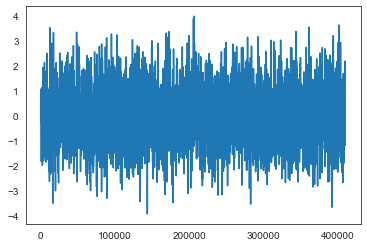

In [20]:
plt.plot(kfreq,Fx)

In [21]:
max(kfreq)

409600.0

In [22]:
Fx1 = Fx.copy()    ## Making the copies so that I don't alter the original signal by mistake
Fy1 = Fy.copy()
Fx2 = Fx.copy()
Fy2 = Fy.copy()

### Defining the faraday rotation angle

In [23]:
# freqeuncies for faraday rotation
freq = (kfreq[1:])*1e2
far_rot = np.zeros(len(kfreq[1:]))
for i in range(len(freq)):
    far_rot[i] = faraday_rotation_angle(freq[i])
    Fx2[i] = Fx1[i]*np.cos(far_rot[i]/2)+Fy1[i]*np.sin(far_rot[i]/2)
    Fy2[i] = -Fx1[i]*np.sin(far_rot[i]/2)+Fy1[i]*np.cos(far_rot[i]/2)
    
## Fx2 and Fy2 are the final signals in fourier space after faraday rotation

In [24]:
sx1 = np.fft.irfft(Fx2)
sy1 = np.fft.irfft(Fy2)
len(sx1)
## sx1 and sy1 are signals in time space after faraday rotation with 

8192

####  Stokes parameters after Far. rotation

In [25]:
Pxx1 = PS(Fx2)
Pyy1 = PS(Fy2)
Pxy1 = PS(Fx2,Fy2)
Pyx1 = PS(Fy2,Fx2)
I1 = Pxx1+Pyy1
Q1 = Pxx1-Pyy1
U1 = np.real(Pxy1+Pyx1)
V1 = np.imag(Pxy1-Pyx1)
N1 = np.mean(I1)
I1/=N1
Q1/=N1
U1/=N1
V1/=N1

prod (4097,)
prod (4097,)
prod (4097,)
prod (4097,)


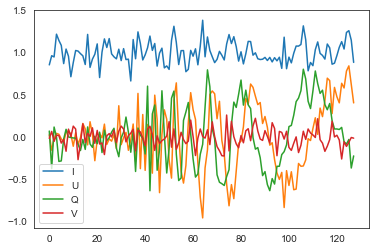

In [26]:
plt.plot(I1,label="I")
plt.plot(U1,label="U")
plt.plot(Q1,label="Q")
plt.plot(V1,label="V")
plt.legend()


#### The U and Q are the ones that are varied during faraday rotation and they have changed a lot compared to their respective values before rotation

### IN the four cells below this, I'm trying to see if by averaging before would it make any sense. I was following your lead on length of 32, maybe this can be changed.

## Was just trying out stuff like understanding the averaging in python array. NOthing important

In [27]:
#binPks = sx1.reshape((2**5,-1)).mean(axis=-1)

In [28]:
#binPkfre = kfreq[1:len(kfreq)].reshape((2**5,-1)).mean(axis=-1)

In [29]:
#far_rot2 = far_rot[len(far_rot)-1].reshape((2**5,-1)).mean(axis=-1)
#for i in range(len(binPkfre)):
    
 #   far_rot2[i] = faraday_rotation_angle(binPkfre[i])

In [30]:
#plt.semilogx(binPkfre,far_rot2)

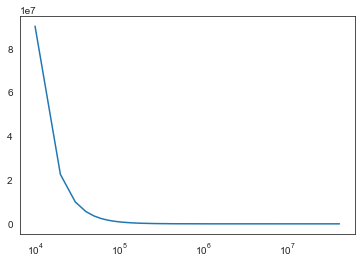

In [31]:
plt.semilogx(freq,far_rot)

## The PFB part starts here, for a start I was using the basic code that was written in the PFB introductory jupyter notebook https://github.com/telegraphic/pfb_introduction and trying to see if I can include our data into that basic code. 


In [32]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [33]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

In [34]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

#### In the code below where its commented, trimming of the array. I didn't do that because, it was removing some data from the set in the original PFB sample code which we don't want. Hence I commented it out.

In [35]:
def pfb_spectrometer(x,y, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)
    plt.plot(win_coeffs)
    plt.title("Window coefficients the sinc function")
    plt.show()

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    print("xfir",x_fir.shape)
    x_pfb = fft(x_fir, P)
    
    y_fir = pfb_fir_frontend(y, win_coeffs, M, P)
    y_pfb = fft(y_fir, P)
   
    x_psd = np.abs(x_pfb)**2
    y_psd = np.abs(y_pfb)**2
    xy_psd = x_pfb*np.conj(y_pfb)
    yx_psd = y_pfb*np.conj(x_pfb)
    
    
    rxy_psd = np.real(xy_psd+yx_psd)
    imxy_psd = np.imag(xy_psd-yx_psd)
    
    
    
    # Trim array so we can do time integration
    #x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    #print(x_psd.shape)
    #y_psd = y_psd[:np.round(y_psd.shape[0]//n_int)*n_int]
    #rxy_psd = rxy_psd[:np.round(rxy_psd.shape[0]//n_int)*n_int]
    #imxy_psd = imxy_psd[:np.round(imxy_psd.shape[0]//n_int)*n_int]

    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    #print(x_psd.shape)
    y_psd = y_psd.reshape(y_psd.shape[0]//n_int, n_int, y_psd.shape[1])
    rxy_psd = rxy_psd.reshape(rxy_psd.shape[0]//n_int, n_int, rxy_psd.shape[1])
    imxy_psd = imxy_psd.reshape(imxy_psd.shape[0]//n_int, n_int, imxy_psd.shape[1])
    
    
    x_psd = x_psd.mean(axis=1)
    #print(x_psd.shape)
    y_psd = y_psd.mean(axis=1)
    rxy_psd = rxy_psd.mean(axis=1)
    imxy_psd = imxy_psd.mean(axis=1)
    

    
    return x_psd,y_psd,rxy_psd,imxy_psd

#### THe values are chosen such that the M*P*W gives us the number of elements in the main signal array. Which in our original case is 8192. THe value of P is chosen to have 128 finals bins(Same number of bins as the averaging for the source stokes parameters in Cell [9]

In [36]:
datax = sx1
datay = sy1
M = 4
P = 2**8
W = 2**3

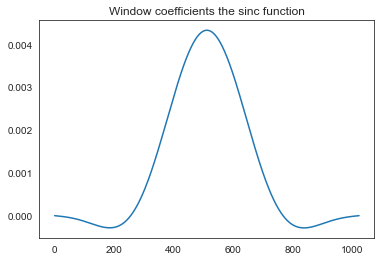

xfir (28, 256)


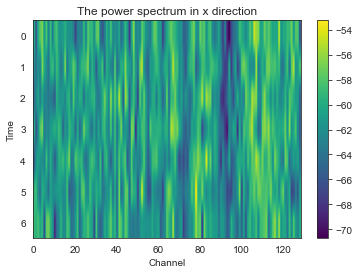

In [37]:
X_psd,Y_psd,RXY_psd,IMXY_psd = pfb_spectrometer(datax, datay, n_taps=M, n_chan=P, n_int=4, window_fn="hamming")
#print(len(X_psd))
#print(len(Y_psd))
#print(len(RXY_psd))
#print(len(IMXY_psd))

plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.title("The power spectrum in x direction")
plt.show()


#### The below 4-5 cells are just for understanding how the averaging works in python. Can we commented out which I did.

In [38]:
#Y_psd.shape

In [39]:
#X_psd[:,:-1].shape

In [40]:
#Y = Y_psd[:,:-1].reshape((32,-1))

In [41]:
#Y.shape

In [42]:
#print(IMXY_psd)

In [43]:
X_psd = X_psd[:,1:].mean(axis=0)
Y_psd = Y_psd[:,1:].mean(axis=0)
RXY_psd = RXY_psd[:,1:].mean(axis=0)
IMXY_psd = IMXY_psd[:,1:].mean(axis=0)

print(X_psd.shape)
print(Y_psd.shape)
print(RXY_psd.shape)
print(IMXY_psd.shape)


I2 = X_psd+Y_psd
Q2 = X_psd-Y_psd
U2 = RXY_psd
V2 = -IMXY_psd
N2 = np.mean(I2)
I2/=N2
Q2/=N2
U2/=N2
V2/=N2


(128,)
(128,)
(128,)
(128,)


In [44]:
#print(I2**2)

In [45]:
#print(Q2**2+U2**2+V2**2)

In [46]:
#np.shape(X_psd)

In [47]:
#print(U2)

In [48]:
#print(U1)

In [49]:
#print(V2)

Text(0.5, 1.0, 'Stokes parameters of Faraday rotated signal using PFB')

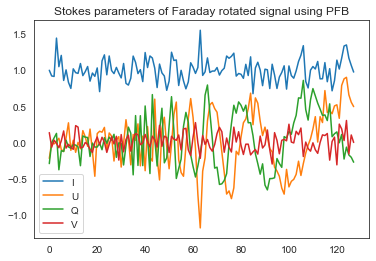

In [50]:
plt.plot(I2,label="I")
plt.plot(U2,label="U")
plt.plot(Q2,label="Q")
plt.plot(V2,label="V")
plt.legend()
plt.title("Stokes parameters of Faraday rotated signal using PFB")

Text(0.5, 1.0, 'Stokes Parameters of Faraday rotated signal using Faraday rotation formula')

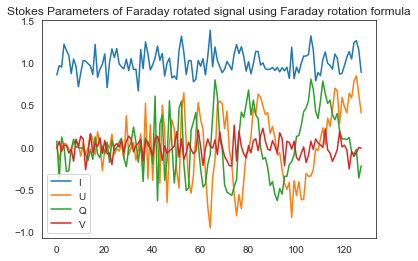

In [51]:
plt.plot(I1,label="I")
plt.plot(U1,label="U")
plt.plot(Q1,label="Q")
plt.plot(V1,label="V")
plt.legend()
plt.title("Stokes Parameters of Faraday rotated signal using Faraday rotation formula")

Text(0.5, 1.0, 'Original signal at the source')

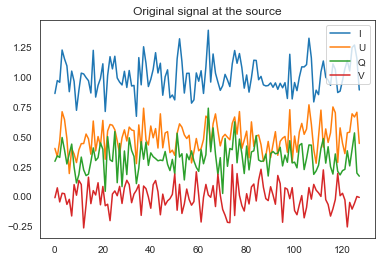

In [52]:
plt.plot(I,label="I")
plt.plot(U,label="U")
plt.plot(Q,label="Q")
plt.plot(V,label="V")
plt.legend()
plt.title("Original signal at the source")

### By looking at the above plots, the plots generated by the PFB and the one generated normally using the Faraday rotation formula look similar. Further changes can be made to make it more better such as increasing the bins as per frequency. The lower the frequency, the more number of bins so as not to destroy the faraday rotation because of the averaging.?